## Этот датасет взят из [Kaggle](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/data) для задач HR-аналитики и предсказания оттока сотрудников

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>
    
**Кратко о чём тут:**
- Проект - `IBM HR Analytics Employee Attrition`
- Суть - данные о 1470 сотрудниках одной компании
- Главная цель - понять, почему сотрудники уходят
- Параметры:
  - Демография: возраст, пол, семейное положение, расстояние до работы
  - Работа: отдел, должность, уровень позиции, зарплата (ежемесячная, почасовая, дневная), сверхурочные
  - Удовлетворённость: работой, условиями, балансом работы/жизни, отношениями с коллегами/руководителем
  - Карьера: стаж в компании, в роли, с текущим менеджером, сколько компаний сменил, повышения, обучения
  - Производительность: рейтинг, процент повышения зарплаты
  - Целевая переменная: Attrition - уволился ли сотрудник (Yes/No)

________________________________________________________
**Основная задача:**
- Выяснить причины увольнения сотрудников

**Предложенные возможные гипотезы увольнения:**
- Низкая заработная плата
- Переработки
- Молодой возраст
- Одиночки (семейное положение - Не женат / не замужем)


**Дополнительные вопросы:**

1. Из какого отдела чаще увольняются
2. Как расстояние влияет на отток
3. `Чем вызвана неудовлетворенность сотрудников`
4. Кто из чаще уходи мужины или женщины
5. Количество обучений, как сказывается на производительность.
6. Как стаж в компании влияют на уволеность

# Импорты и функции

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import shapiro, mannwhitneyu, ttest_ind, chi2_contingency, fisher_exact

In [2]:
# Информация о DS
def summarize(DataFrame):
    summary = pd.DataFrame()
    summary['type'] = DataFrame.dtypes
    summary['sum_nan'] = DataFrame.isna().sum()
    summary['%_nan'] = round(DataFrame.isna().sum() / len(DataFrame) * 100, 2)
    summary['unique'] = DataFrame.apply(lambda x: ', '.join(map(str, x.unique())) if len(x.unique()) <= 8 else len(x.unique()))
    summary['mode'] = DataFrame.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else '-')
    
    # Проверяем, что тип данных числовой (int или float) и НЕ булевый
    def is_numeric_non_bool(dtype):
        return pd.api.types.is_numeric_dtype(dtype) and not pd.api.types.is_bool_dtype(dtype)

    # Применяем числовые статистики только к подходящим столбцам
    summary['max'] = DataFrame.apply(lambda x: x.max() if is_numeric_non_bool(x) else '-')
    summary['75_quantile'] = DataFrame.apply(lambda x: round(x.quantile(0.75), 2) if is_numeric_non_bool(x) else '-')
    summary['median'] = DataFrame.apply(lambda x: round(x.median(), 2) if is_numeric_non_bool(x) else '-')
    summary['25_quantile'] = DataFrame.apply(lambda x: round(x.quantile(0.25), 2) if is_numeric_non_bool(x) else '-')
    summary['min'] = DataFrame.apply(lambda x: x.min() if is_numeric_non_bool(x) else '-')
    summary['mean'] = DataFrame.apply(lambda x: round(x.mean(), 2) if is_numeric_non_bool(x) else '-')
    summary['standard_deviation'] = DataFrame.apply(lambda x: round(x.std(), 2) if is_numeric_non_bool(x) else '-')

    # Сортировка по type
    summary['type'] = summary['type'].astype(str)
    type_order = ['int64', 'float64', 'bool', 'category', 'datetime64[ns]', 'object']
    summary['type'] = pd.Categorical(summary['type'], categories=type_order, ordered=True)
    summary = summary.sort_values(by='type')
    summary['type'] = summary['type'].astype(str)

    return summary

# Первичный вывод информации

In [3]:
df = pd.read_csv('Attrition.csv')

In [4]:
print(df.shape)
summarize(df)

(1470, 35)


,type,sum_nan,%_nan,unique,mode,max,75_quantile,median,25_quantile,min,mean,standard_deviation
Age,int64,0,0.0,43,35,60,43.0,36.0,30.0,18,36.92,9.14
YearsInCurrentRole,int64,0,0.0,19,2,18,7.0,3.0,2.0,0,4.23,3.62
YearsAtCompany,int64,0,0.0,37,5,40,9.0,5.0,3.0,0,7.01,6.13
WorkLifeBalance,int64,0,0.0,"1, 3, 2, 4",3,4,3.0,3.0,2.0,1,2.76,0.71
TrainingTimesLastYear,int64,0,0.0,"0, 3, 2, 5, 1, 4, 6",2,6,3.0,3.0,2.0,0,2.8,1.29
TotalWorkingYears,int64,0,0.0,40,10,40,15.0,10.0,6.0,0,11.28,7.78
StockOptionLevel,int64,0,0.0,"0, 1, 3, 2",0,3,1.0,1.0,0.0,0,0.79,0.85
StandardHours,int64,0,0.0,80,80,80,80.0,80.0,80.0,80,80.0,0.0
RelationshipSatisfaction,int64,0,0.0,"1, 4, 2, 3",3,4,4.0,3.0,2.0,1,2.71,1.08
PerformanceRating,int64,0,0.0,"3, 4",3,4,3.0,3.0,3.0,3,3.15,0.36


In [5]:
df[df.duplicated(subset=df.columns.drop('EmployeeNumber'))]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


In [6]:
df.drop(['Over18', 'EmployeeCount', 'StandardHours'],axis=1, inplace=True)

| Колонка                      | Описание                                              |
|------------------------------|-------------------------------------------------------|
| Age                          | Возраст сотрудника                                    |
| Attrition                    | Увольнение / Отток (Yes/No - целевая переменная)      |
| BusinessTravel               | Частота командировок (Rarely, Frequently, No Travel)  |
| DailyRate                    | Дневная ставка / Дневной заработок                    |
| Department                   | Отдел / Департамент                                   |
| DistanceFromHome             | Расстояние от дома до работы (в км или милях)         |
| Education                    | Уровень образования (1-5)                             |
| EducationField               | Направление / область полученного образования         |
| EmployeeCount                | Количество сотрудников (константа, обычно = 1)        |
| EmployeeNumber               | Уникальный номер / ID сотрудника                      |
| EnvironmentSatisfaction      | Удовлетворённость условиями труда (1-4)               |
| Gender                       | Пол (Male / Female)                                   |
| HourlyRate                   | Почасовая ставка                                      |
| JobInvolvement               | Вовлечённость в работу (1-4)                          |
| JobLevel                     | Уровень / грейд должности (1-5)                       |
| JobRole                      | Должность / роль в компании                           |
| JobSatisfaction              | Удовлетворённость самой работой (1-4)                 |
| MaritalStatus                | Семейное положение (Single / Married / Divorced)      |
| MonthlyIncome                | Ежемесячный доход / зарплата                          |
| MonthlyRate                  | Ежемесячная ставка (расчётная, не всегда = доход)     |
| NumCompaniesWorked           | Количество компаний, где работал ранее                |
| Over18                       | Старше 18 лет (константа, Yes)                        |
| OverTime                     | Работает ли сверхурочно (Yes/No)                      |
| PercentSalaryHike            | Процент повышения зарплаты за последний год           |
| PerformanceRating            | Оценка производительности (обычно 3-4)                |
| RelationshipSatisfaction     | Удовлетворённость отношениями с коллегами (1-4)       |
| StandardHours                | Стандартное количество рабочих часов (обычно = 80)    |
| StockOptionLevel             | Уровень опционов на акции (0-3)                       |
| TotalWorkingYears            | Общий трудовой стаж (в годах)                         |
| TrainingTimesLastYear        | Количество обучений / тренингов за последний год     |
| WorkLifeBalance              | Баланс работы и жизни (оценка 1-4)                    |
| YearsAtCompany               | Стаж работы в текущей компании (в годах)              |
| YearsInCurrentRole           | Стаж в текущей должности / роли (в годах)             |
| YearsSinceLastPromotion      | Сколько лет прошло с последнего повышения            |
| YearsWithCurrManager         | Стаж работы с текущим руководителем (в годах)         |

In [7]:
df = df.replace({

    'JobRole': {
        'Sales Executive': 'Менеджер по продажам',
        'Research Scientist': 'Научный сотрудник',
        'Laboratory Technician': 'Лаборант',
        'Manufacturing Director': 'Директор производства',
        'Healthcare Representative': 'Медпредставитель',
        'Manager': 'Менеджер',
        'Sales Representative': 'Торговый представитель',
        'Research Director': 'Директор по исследованиям',
        'Human Resources': 'HR-специалист'
    },

    'EducationField': {
        'Life Sciences': 'Естественные науки',
        'Medical': 'Медицина',
        'Marketing': 'Маркетинг',
        'Technical Degree': 'Техническое',
        'Human Resources': 'Управление персоналом',
        'Other': 'Другое'
    },

    'Gender': {
        'Male': 'Мужчина',
        'Female': 'Женщина'
    },

    'Department': {
        'Sales': 'Продажи',
        'Research & Development': 'Исследования и разработки',
        'Human Resources': 'HR'
    },

    'BusinessTravel': {
        'Travel_Rarely': 'Редкие командировки',
        'Travel_Frequently': 'Частые командировки',
        'Non-Travel': 'Без командировок'
    },

    'Attrition': {
        'Yes': 'Да',
        'No': 'Нет'
    },

    'OverTime': {
        'Yes': 'Да',
        'No': 'Нет'
    },

    'MaritalStatus': {
        'Single': 'Не женат / не замужем',
        'Married': 'В браке',
        'Divorced': 'Разведён(а)'
    }

})

df = df.rename(columns={
    'Age': 'Возраст',
    'Attrition': 'Увольнение',
    'BusinessTravel': 'Командировки',
    'DailyRate': 'Дневная ставка',
    'Department': 'Отдел',
    'DistanceFromHome': 'Расстояние до работы в км',
    'Education': 'Уровень образования',
    'EducationField': 'Область образования',
    'EmployeeNumber': 'ID сотрудника',
    'EnvironmentSatisfaction': 'Удовлетворённость условиями труда',
    'Gender': 'Пол',
    'HourlyRate': 'Почасовая ставка',
    'JobInvolvement': 'Вовлечённость в работу',
    'JobLevel': 'Грейд',
    'JobRole': 'Должность',
    'JobSatisfaction': 'Удовлетворённость работой',
    'MaritalStatus': 'Семейное положение',
    'MonthlyIncome': 'Месячный доход',
    'MonthlyRate': 'Сколько стоит сотрудник в месяц',
    'NumCompaniesWorked': 'Количество компаний, где работал ранее',
    'OverTime': 'Сверхурочная работа',
    'PercentSalaryHike': 'Рост зарплаты (%)',
    'PerformanceRating': 'Оценка эффективности',
    'RelationshipSatisfaction': 'Отношения с коллегами',
    'StockOptionLevel': 'Уровень опционов на акции',
    'TotalWorkingYears': 'Общий стаж в годах',
    'TrainingTimesLastYear': 'Обучений за год',
    'WorkLifeBalance': 'Баланс работа-жизнь',
    'YearsAtCompany': 'Стаж в компании',
    'YearsInCurrentRole': 'Стаж в роли',
    'YearsSinceLastPromotion': 'Лет без повышения',
    'YearsWithCurrManager': 'Стаж с руководителем'
})



# Первичный вывод

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>


- Имеется 3 колонки с 1 уникальным значением, избавимся от них
    - `Over18` всегда 'Y'
    - `EmployeeCount` всегда 1
    - `StandardHours` всегда 80
- Полных дубликатов строк нет (проверено по всем колонкам, включая исключения `EmployeeNumber`
- Отсутствуют пропущенные значения (Nan) во всех колонках
- Заменены названия колонок и значения на русский язык


## Для начала выведем сотрудников которые уволены и какой у них грейд

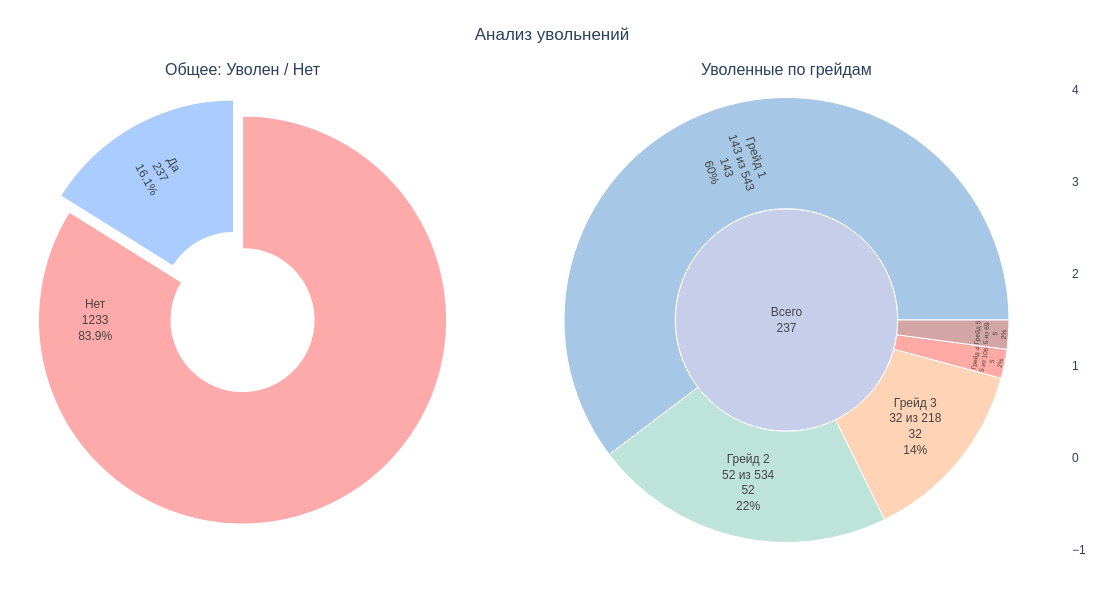

In [8]:
data = df.groupby('Грейд').agg(
    Всего=('Грейд', 'size'),
    Уволено=('Увольнение', lambda x: (x == 'Да').sum())
).reset_index()

data['Все сотрудники'] = 'Всего'

data['label'] = data.apply(
    lambda row: f'Грейд {row['Грейд']}<br>{row['Уволено']} из {row['Всего']}',
    axis=1
)

data['доля_в_грейде'] = (data['Уволено'] / data['Всего'] * 100).round(1)

status_counts = df['Увольнение'].value_counts().reset_index()
status_counts.columns = ['Статус', 'Кол-во']

pastel_colors = [
    '#A7C7E7', '#BEE3DB', '#FFD3B6', '#FFAAA5',
    '#D4A5A5', '#C7CEEA', '#E2D0CA', '#F4C2C2'
]

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'pie'}, {'type': 'sunburst'}]],
    subplot_titles=(
        'Общее: Уволен / Нет',
        'Уволенные по грейдам'
    )
)

fig.add_trace(
    go.Pie(
        labels=status_counts['Статус'],
        values=status_counts['Кол-во'],
        textinfo='label+percent+value',
        hole=0.35,
        textposition='inside',
        insidetextorientation='radial',
        pull=[0.09 if s == 'Да' else 0 for s in status_counts['Статус']],
        marker=dict(
            colors=['#ffaaaa', '#aaccff'], 
            line=dict(color='#ffffff', width=1.2)
        )
    ),
    row=1, col=1
)

sun = px.sunburst(
    data,
    path=['Все сотрудники', 'label'],
    values='Уволено',
    color='Грейд',
    maxdepth=2,
    branchvalues='total'
)

sun.update_traces(
    marker=dict(
        colors=pastel_colors * (len(data) // len(pastel_colors) + 1) 
    ),
    selector=dict(type='sunburst')
)

fig.add_trace(sun.data[0], row=1, col=2)

fig.update_traces(
    hovertemplate=(
        '<b>%{label}</b><br>' +
        'Уволено: %{value}<br>' +
        'Всего в грейде: %{customdata[0]}<br>' +
        'Доля внутри грейда: %{customdata[1]}%<extra></extra>'
    ),
    customdata=list(zip(data['Всего'], data['доля_в_грейде'])),
    textinfo='label+value+percent entry',
    selector=dict(type='sunburst')
)

fig.update_layout(
    title_text='Анализ увольнений',
    title_x=0.5,
    height=600,
    width=1100,
    margin=dict(t=80, l=20, r=20, b=40),
    showlegend=False
)

fig.show()

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

**В результате анализа было уволено 16% сотрудников, что составляет 237 человек. Распределение уволенных сотрудников по грейдам представлено следующим образом:**

    * Сотрудники первого грейда: 143 человека, что составляет 26,3% от общего числа сотрудников данного грейда.
    * Сотрудники второго грейда: 52 человека, что составляет 9,7% от общего числа сотрудников данного грейда.
    * Сотрудники третьего грейда: 32 человека, что составляет 14,7% от общего числа сотрудников данного грейда.
    * Сотрудники четвёртого грейда: 5 человек, что составляет 4,7% от общего числа сотрудников данного грейда.
    * Сотрудники пятого грейда: 5 человек, что составляет 7,2% от общего числа сотрудников данного грейда.

- Анализ причин увольнений показывает, что сотрудники первого грейда увольняются чаще всего. Это может быть связано с тем, что на начальном этапе работы не всегда ясно, насколько сотруднику понравится работать в данной компании. Текучесть кадров среди сотрудников первого грейда может быть оправдана. В дальнейшем планируется провести более детальное исследование причин увольнений среди сотрудников первого грейда.

- Сотрудники второго и более высоких грейдов увольняются реже. Однако для более глубокого понимания причин увольнений среди этих сотрудников необходимо провести дополнительное исследование.

- Данных по сотрудникам четвёртого и пятого грейдов недостаточно для формирования окончательных выводов. Однако можно предположить, что сотрудники с более высоким грейдом увольняются чаще, чем сотрудники с четвёртым грейдом. Это может быть связано с тем, что сотрудники, достигшие определённого уровня в компании, могут потерять интерес к дальнейшему развитию и начать искать новые возможности для профессионального роста.


## Проверка гипотезы: «Сотрудники увольняются из-за низкой заработной платы»

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

**H0:**  
Месячный доход уволившихся и оставшихся сотрудников не различается (внутри каждого грейда).

**H1:**  
У уволившихся сотрудников месячный доход ниже, чем у оставшихся.

Проверка проводится с помощью теста Шапиро-Уилка - выбор t-теста Стьюдента или теста Манна-Уитни (в зависимости от нормальности).  
Уровень значимости alpha = 0.05.

In [9]:
alpha = 0.05

for i in sorted(df['Грейд'].unique()):
    x = df[(df['Увольнение'] == 'Да') & (df['Грейд'] == i)]['Месячный доход']
    y = df[(df['Увольнение'] == 'Нет') & (df['Грейд'] == i)]['Месячный доход']
    
    print(f'\nГрейд {i}')
    print('Тест: Шапиро Уилка')
    print(f'Размер выборок: уволились = {len(x)}, остались = {len(y)}')
    
    p_x = shapiro(x).pvalue
    p_y = shapiro(y).pvalue
    
    normal = (p_x > alpha) and (p_y > alpha)
    
    if (p_x > alpha) and (p_y > alpha):
        normality_text = 'распределения нормальное'
    else:
        normality_text = 'распределения не нормальные'
    
    print(
        f'Нормальность: уволились p_x={p_x:.3g}, '
        f'остались p_y={p_y:.3g} - {normality_text}'
    )    
    stat, p_value = mannwhitneyu(x, y, alternative='less')
    test_name = 'Манна Уитни'
    
    n1, n2 = len(x), len(y)
    rbc = 1 - (2 * stat) / (n1 * n2)
    effect = f'Rank-biserial r = {rbc:.3f}'
    
    decision = 'Зарплаты не равны' if p_value < alpha else 'Зарплаты приблизительно равны '
    
    print(f'Тест: {test_name}')
    print(f'p-value = {p_value:.3g} - {decision}')
    print(effect)


Грейд 1
Тест: Шапиро Уилка
Размер выборок: уволились = 143, остались = 400
Нормальность: уволились p_x=0.000344, остались p_y=2.75e-09 - распределения не нормальные
Тест: Манна Уитни
p-value = 0.000206 - Зарплаты не равны
Rank-biserial r = 0.199

Грейд 2
Тест: Шапиро Уилка
Размер выборок: уволились = 52, остались = 482
Нормальность: уволились p_x=5.64e-05, остались p_y=8.79e-12 - распределения не нормальные
Тест: Манна Уитни
p-value = 0.847 - Зарплаты приблизительно равны 
Rank-biserial r = -0.086

Грейд 3
Тест: Шапиро Уилка
Размер выборок: уволились = 32, остались = 186
Нормальность: уволились p_x=0.13, остались p_y=0.000266 - распределения не нормальные
Тест: Манна Уитни
p-value = 0.0803 - Зарплаты приблизительно равны 
Rank-biserial r = 0.156

Грейд 4
Тест: Шапиро Уилка
Размер выборок: уволились = 5, остались = 101
Нормальность: уволились p_x=0.504, остались p_y=2.32e-06 - распределения не нормальные
Тест: Манна Уитни
p-value = 0.00201 - Зарплаты не равны
Rank-biserial r = 0.766

Г

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>
    
**Вывод по влиянию зарплаты на увольнение в разрезе грейдов**

Проверялась гипотеза:  
H0 - месячный доход уволившихся и оставшихся сотрудников не различается (внутри каждого грейда)  
H1 - уволившиеся зарабатывали меньше, чем оставшиеся


- **Грейд 1**: H0 отвергается (p = 0.0002), `данные поддерживают H1`. Низкая зарплата значимо связана с увольнением.
- **Грейды 2, 3, 5**: `Нет оснований отвергнуть H0` (p > 0.05) - связь между зарплатой и увольнением не подтверждена.
- **Грейд 4**: Формально H0 отвергается (p = 0.002, большой эффект), но из-за крайне малого количества уволившихся (n = 5) результат имеет низкую надёжность и требует осторожной интерпретации.

**Общий вывод по гипотезе**:  
`Гипотеза` о том, что низкая заработная плата способствует увольнению, `получает статистическую поддержку только на младших грейдах`. На средних и старших уровнях значимого влияния зарплаты не выявлено.

## Проверка гипотезы: «Сотрудники увольняются из-за переработок»

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

**H0:**   
Переработки не связаны с вероятностью уволившихся среди тех, кто работает сверхурочно, не отличается от тех, кто не работает сверхурочно.

**H1:**  
Сотрудники, которые работают сверхурочно, имеют статистически значимо более высокую вероятность увольнения, чем сотрудники, не привлекаемые к переработкам.

In [10]:
for i in sorted(df['Грейд'].unique()):
    subset = df[df['Грейд'] == i]
    
    if len(subset) < 10:
        print(f'\nГрейд {i} - слишком мало данных')
        continue
        
    crosstab = pd.crosstab(subset['Сверхурочная работа'], subset['Увольнение'])
    print(f'\nГрейд {i}')
    print(crosstab)
    
    if crosstab.min().min() < 5:
        print('Мало ожидаемых частот - точный тест Фишера')
        oddsratio, p_value = fisher_exact(crosstab)
        test_name = 'Точный тест Фишера'
    else:
        chi2, p_value, dof, expected = chi2_contingency(crosstab)
        test_name = 'Хи-квадрат'
    
    pct_overtime_yes = crosstab.loc['Да', 'Да'] / crosstab.loc['Да'].sum() * 100 if 'Да' in crosstab.index else 0
    pct_overtime_no  = crosstab.loc['Нет', 'Да'] / crosstab.loc['Нет'].sum() * 100 if 'Нет' in crosstab.index else 0
    
    print(f'Уволились среди перерабатывающих: {pct_overtime_yes:.1f}%')
    print(f'Уволились среди НЕ перерабатывающих: {pct_overtime_no:.1f}%')
    print(f'{test_name}, p-value = {p_value:.4f}')
    print('Вывод:', 'Значимая связь' if p_value < alpha else 'Нет значимой связи')


Грейд 1
Увольнение           Да  Нет
Сверхурочная работа         
Да                   82   74
Нет                  61  326
Уволились среди перерабатывающих: 52.6%
Уволились среди НЕ перерабатывающих: 15.8%
Хи-квадрат, p-value = 0.0000
Вывод: Значимая связь

Грейд 2
Увольнение           Да  Нет
Сверхурочная работа         
Да                   26  120
Нет                  26  362
Уволились среди перерабатывающих: 17.8%
Уволились среди НЕ перерабатывающих: 6.7%
Хи-квадрат, p-value = 0.0002
Вывод: Значимая связь

Грейд 3
Увольнение           Да  Нет
Сверхурочная работа         
Да                   13   50
Нет                  19  136
Уволились среди перерабатывающих: 20.6%
Уволились среди НЕ перерабатывающих: 12.3%
Хи-квадрат, p-value = 0.1697
Вывод: Нет значимой связи

Грейд 4
Увольнение           Да  Нет
Сверхурочная работа         
Да                    3   30
Нет                   2   71
Мало ожидаемых частот - точный тест Фишера
Уволились среди перерабатывающих: 9.1%
Уволились сре

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

**Во всех грейдах сотрудники, которые работают сверхурочно, увольняются чаще, чем те, кто переработок избегает** 
- На младших грейдах (1-3) эта разница статистически значимая и довольно выраженная - `H0` об отсутствии связи между сверхурочной работой и вероятностью увольнения отклоняется p < 0,05

- На старших грейдах (4-5) направление эффекта сохраняется, но из-за малого количества наблюдений (особенно уволившихся) уверенно утверждать о силе эффекта гиптезы H1 становится сложнее. Во многих случаях H0 формально отклоняется, однако результаты имеют низкую статистическую мощность, широкие доверительные интервалы и могут быть неустойчивыми при увеличении выборки


**Следующий логичный вопрос:** 

Если переработки ассоциированы с повышенным риском увольнения почти на всех уровнях, то возникает гипотеза, что переработки часто являются вынужденной мерой для компенсации относительно высоким планом для сотрудника. Поэтому стоит проверить:

- Действительно ли сотрудники, которые регулярно перерабатывают, получают в среднем меньшую базовую зарплату по сравнению с теми, кто переработок избегает?
- Насколько сильно различается месячный доход между группами «Сверхурочная работа = Да» и «Нет» внутри каждого грейда?

Если подтвердится, что переработки чаще встречаются у людей с более низкой оплатой - это будет важным сигналом для компании: переработки в таком случае скорее фактор риска выгорания и оттока, чем инструмент мотивации.

### Дополнительная гипотеза. Переработки и зарплата 

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

**H0:**  
Месячный доход сотрудников, которые работают сверхурочно, не отличается или выше, чем у тех, кто не перерабатывает, внутри каждого грейда.

**H1:**  
Сотрудники, которые регулярно перерабатывают, получают статистически значимо меньшую базовую зарплату по сравнению с теми, кто переработок избегает.

In [11]:
for i in sorted(df['Грейд'].unique()):
    subset = df[df['Грейд'] == i]
    
    x = subset[subset['Сверхурочная работа'] == 'Да']['Месячный доход']
    y = subset[subset['Сверхурочная работа'] == 'Нет']['Месячный доход']
    
    print(f'\nГрейд {i}')
    print(f'Перерабатывают (Да): {len(x)} чел, медиана = {x.median():,.0f}, среднее = {x.mean():,.0f}')
    print(f'Не перерабатывают (Нет): {len(y)} чел, медиана = {y.median():,.0f}, среднее = {y.mean():,.0f}')
    
    if len(x) < 5 or len(y) < 5:
        print('Недостаточно данных для теста')
        continue
    
    p_x = shapiro(x).pvalue
    p_y = shapiro(y).pvalue
    normal = (p_x > alpha) and (p_y > alpha)
        
    stat, p_value = mannwhitneyu(x, y, alternative='less')
    test_name = 'Mann-Whitney'
    rbc = 1 - (2 * stat) / (len(x) * len(y))
    effect = f'Rank-biserial r = {rbc:.3f}'
    
    decision = 'Разница значима, нулевая гепотеза откланяется (H1)' if p_value < alpha else 'Значимой разницы нет (H0 не отвергается)'
    
    print(f'{test_name}, p-value = {p_value:.4f} - {decision}')
    print(effect)


Грейд 1
Перерабатывают (Да): 156 чел, медиана = 2,657, среднее = 2,803
Не перерабатывают (Нет): 387 чел, медиана = 2,690, среднее = 2,781
Mann-Whitney, p-value = 0.5231 - Значимой разницы нет (H0 не отвергается)
Rank-biserial r = -0.003

Грейд 2
Перерабатывают (Да): 146 чел, медиана = 5,476, среднее = 5,568
Не перерабатывают (Нет): 388 чел, медиана = 5,296, среднее = 5,478
Mann-Whitney, p-value = 0.8670 - Значимой разницы нет (H0 не отвергается)
Rank-biserial r = -0.062

Грейд 3
Перерабатывают (Да): 63 чел, медиана = 10,209, среднее = 9,996
Не перерабатывают (Нет): 155 чел, медиана = 9,824, среднее = 9,745
Mann-Whitney, p-value = 0.7945 - Значимой разницы нет (H0 не отвергается)
Rank-biserial r = -0.071

Грейд 4
Перерабатывают (Да): 33 чел, медиана = 14,411, среднее = 15,102
Не перерабатывают (Нет): 73 чел, медиана = 16,328, среднее = 15,685
Mann-Whitney, p-value = 0.0928 - Значимой разницы нет (H0 не отвергается)
Rank-biserial r = 0.161

Грейд 5
Перерабатывают (Да): 18 чел, медиана =

### Вывод по гипотезе о связи переработок и зарплаты

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>
    
- `Ни в одном грейде не удалось отвергнуть нулевую гипотезу H0` об отсутствии различий в месячном доходе между сотрудниками, которые работают сверхурочно, и теми, кто этого не делает (все p > 0.05, за исключением близкого к значимости результата на грейде 4).
- Средние и медианные значения зарплаты в группах «Сверхурочная работа = Да» и «Нет» практически совпадают на большинстве грейдов.
`На грейде 4 наблюдается противоположное направление`: сотрудники без переработок в среднем и по медиане получают несколько больше (разница -1900 по медиане), но статистическая значимость не достигнута (p = 0.093), а выборка мала.

Из этого следует, что связь между сверхурочной работой и повышенным риском увольнения не объясняется различиями в уровне оплаты.
Переработки, судя по всему, не являются инструментом дополнительного заработка или компенсации низкой базовой зарплаты.
Более вероятные объяснения повышенного оттока среди перерабатывающих сотрудников:

- накопление усталости и выгорание
- нарушение work-life balance
- ощущение несправедливости («много работаю, но не получаю за это дополнительно»)
- личные особенности (например, более низкая скорость выполнения задач, трудности с концентрацией или планированием)
- организационные факторы (нереалистичные дедлайны, недостаток ресурсов, культура переработок)

## Гипотеза что возраст влияет на отток

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

**H0:**  
Возраст сотрудника не оказывает влияния на отток сотрудников

**H1:**  
Возраст сотрудника оказывает влияние на отток сотрудников

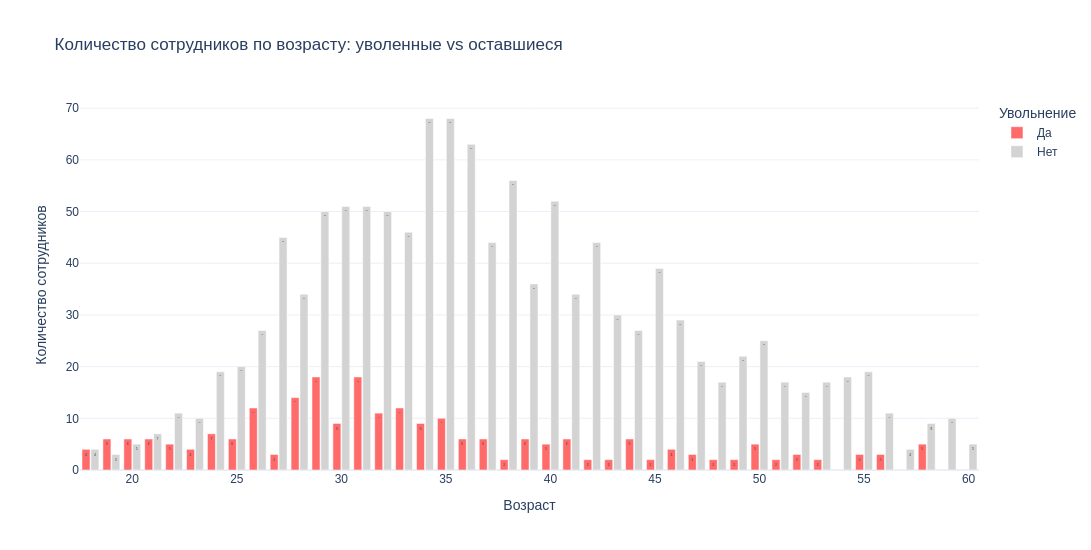

In [12]:
counts = df.groupby(['Возраст', 'Увольнение']).size().reset_index(name='Количество')

fig = px.bar(
    counts,
    x='Возраст',
    y='Количество',
    color='Увольнение',
    barmode='group',
    title='Количество сотрудников по возрасту: уволенные vs оставшиеся',
    labels={
        'Возраст': 'Возраст',
        'Количество': 'Количество человек',
        'Увольнение': 'Статус'
    },
    color_discrete_map={'Да': '#FF6B6B', 'Нет': 'lightgray'},
    text_auto=True
)

fig.update_layout(
    xaxis_title='Возраст',
    yaxis_title='Количество сотрудников',
    bargap=0.15,
    bargroupgap=0.1,
    legend_title_text='Увольнение',
    template='plotly_white',
    height=550
)

fig.show()

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

- Анализ распределения оттока по возрасту показывает, что среди сотрудников младше 21 года доля уволенных составляет около 50%.
- По мере увеличения возраста наблюдается устойчивое снижение уровня оттока, которое продолжается примерно до 34 лет.
- Начиная с возраста 34 лет, уровень оттока стабилизируется и не демонстрирует выраженной тенденции к дальнейшему снижению.
_______________

- Таким образом, на основе проведённого анализа `можно отвергнуть H0` о независимости возраста и оттока для сотрудников `в возрасте до 34 лет`. 
- В то же время для возрастной группы `34 года и старше оснований для отклонения H0 не выявлено`.

## Гипотеза что одиночки чаще покидают компанию

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

**H0:**  
Семейное положение сотрудника (холост/не замужем, разведён/разведена) не оказывает влияния на вероятность увольнения

**H1:**  
Семейное положение сотрудника (холост/не замужем, разведён/разведена) оказывает влияние на вероятность увольнения

In [13]:
df_v1 = df.copy()

df_v1['Возрастная_группа'] = pd.cut(
    df['Возраст'],
    bins=[17, 25, 34, 101],
    labels=['18-24', '25-33', '34+'],
    right=False,
    include_lowest=True
)

if 'Семейное положение' in df_v1.columns:
    df_v1['Семейный_статус'] = np.where(
        df_v1['Семейное положение'].isin(['Не женат / не замужем', 'Разведён(а)']),
        'Одиночка',
        'В отношениях'
    )

results = []

for i in sorted(df_v1['Возрастная_группа'].dropna().unique()):
    sub = df_v1[df_v1['Возрастная_группа'] == i]
    n = len(sub)
    
    tab = pd.crosstab(sub['Семейный_статус'], sub['Увольнение'])
    
    chi2, p, _, _ = chi2_contingency(tab)
    
    pct_single  = 100 * tab.loc['Одиночка', 'Да'] / tab.loc['Одиночка'].sum()
    pct_family  = 100 * tab.loc['В отношениях', 'Да'] / tab.loc['В отношениях'].sum()
    diff        = pct_single - pct_family
    
    significant = p < alpha
    
    print(f'{i} (Сотрудников {n})')
    print(f'Одиночки:      {pct_single:5.1f}%')
    print(f'В отношениях:  {pct_family:5.1f}%')
    print(f'Разница:       {diff:+6.1f}%')
    print(f'p-value:       {p:.4f}  -  {'Значимо для оповержения H0' if significant else 'Не значимо для оповержения H0'}')
    print('')

18-24 (Сотрудников 97)
Одиночки:       43.3%
В отношениях:   30.0%
Разница:        +13.3%
p-value:       0.3107  -  Не значимо для оповержения H0

25-33 (Сотрудников 477)
Одиночки:       25.2%
В отношениях:   17.1%
Разница:         +8.1%
p-value:       0.0423  -  Значимо для оповержения H0

34+ (Сотрудников 896)
Одиночки:       12.3%
В отношениях:    9.0%
Разница:         +3.3%
p-value:       0.1424  -  Не значимо для оповержения H0



<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    
- Семейное положение было разделено на две группы: «в браке» и «не в браке» (одиночки + разведённые)- очень хорошо, чётко и понятно
- Для более глубокого анализа связи семейного положения с оттоком сотрудники были разбиты на три возрастные группы
- Возрастные группы выбраны следующим образом:
    - 18-24 - самые молодые
    - 25-33 - средний возраст (основная рабочая сила)
    - 34+   - взрослые сотрудники

- Во всех возрастных группах наблюдается одна и та же тенденция, сотрудники, которые не состоят в браке, уходят чаще
____________
- для возраста 18-24 p=0.31 выше остальных групп, `H0 нельзя отвергать`
    - для возраста этой группы можно предположить, что семейный статут оказывает меньшее влияние нежели на другие возраста
- для сотрудников  25-33 p=0.04 что уже `позволяет отвергать H0`
- для сотрудников 34 и выше p=0.14 `не можем отвергать H0`

# Дополнительые вопросы

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>
    
На некоторые вопросы мы уже знаем ответ из предыдущих выводов

1. Из какого отдела чаще увольняются
2. Как расстояние влияет на отток
3. `Чем вызвана неудовлетворенность сотрудников`
4. Кто из чаще уходи мужины или женщины
5. Количество обучений, как сказывается на производительность.
6. Как стаж в компании влияют на уволеность

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    1.Из какого отдела чаще увольняются

In [14]:
pivot = (
    df.pivot_table(
        index='Отдел',
        columns='Увольнение',
        values='ID сотрудника',
        aggfunc='count'
    ))

pivot['%_Да'] = (pivot['Да'] / pivot.sum(axis=1) * 100).round(1)
pivot.sort_values('%_Да',ascending=False)

Увольнение,Да,Нет,%_Да
Отдел,,,
Продажи,92,354,20.6
HR,12,51,19.0
Исследования и разработки,133,828,13.8


<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

- Из отдела `продаж` и `HR` сотрудники `уходят чаще`
- Отдел исследования и разработки содержит 2/3 всех сотрудников 

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    2.Как расстояние влияет на отток

In [15]:
df_v1 = df.copy()
df_v1['Расст_кратное_5'] = (df_v1['Расстояние до работы в км'] // 5) * 5  + 2.5

pivot = df_v1.pivot_table(
    index='Расст_кратное_5',
    columns='Увольнение',
    values='Отдел',
    aggfunc='count'
)

pivot['%_Да'] = (pivot['Да'] / pivot.sum(axis=1) * 100)
pivot

Увольнение,Да,Нет,%_Да
Расст_кратное_5,,,
2.5,77,490,13.580247
7.5,56,317,15.013405
12.5,31,144,17.714286
17.5,24,102,19.047619
22.5,30,87,25.641026
27.5,19,93,16.964286


<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    Расстояние имеет логическую закономерность, сотрудники предпочитают работать ближе к дому, об этом говорить как число работиков, так и % оттока сотрудников

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    3.Чем вызвана неудовлетворенность сотрудников

In [16]:
columns_ = df[['Сверхурочная работа','Пол','Семейное положение','Отдел','Командировки','Увольнение','Удовлетворённость условиями труда']]
for i in columns_:
    tab = pd.crosstab(
        df['Удовлетворённость работой'],
        df[i],
        margins=True
    )
    
    tab[f'%_{tab.columns[0]}'] = tab.iloc[:, 0] / tab['All'] * 100
    display(tab)

Сверхурочная работа,Да,Нет,All,%_Да
Удовлетворённость работой,,,,
1,84,205,289,29.065744
2,69,211,280,24.642857
3,121,321,442,27.375566
4,142,317,459,30.936819
All,416,1054,1470,28.299320


Пол,Женщина,Мужчина,All,%_Женщина
Удовлетворённость работой,,,,
1,119,170,289,41.176471
2,118,162,280,42.142857
3,181,261,442,40.950226
4,170,289,459,37.037037
All,588,882,1470,40.000000


Семейное положение,В браке,Не женат / не замужем,Разведён(а),All,%_В браке
Удовлетворённость работой,,,,,
1,130,89,70,289,44.982699
2,131,88,61,280,46.785714
3,212,136,94,442,47.963801
4,200,157,102,459,43.572985
All,673,470,327,1470,45.782313


Отдел,HR,Исследования и разработки,Продажи,All,%_HR
Удовлетворённость работой,,,,,
1,11,192,86,289,3.806228
2,20,174,86,280,7.142857
3,15,300,127,442,3.393665
4,17,295,147,459,3.703704
All,63,961,446,1470,4.285714


Командировки,Без командировок,Редкие командировки,Частые командировки,All,%_Без командировок
Удовлетворённость работой,,,,,
1,23,215,51,289,7.958478
2,29,202,49,280,10.357143
3,54,304,84,442,12.217195
4,44,322,93,459,9.586057
All,150,1043,277,1470,10.204082


Увольнение,Да,Нет,All,%_Да
Удовлетворённость работой,,,,
1,66,223,289,22.837370
2,46,234,280,16.428571
3,73,369,442,16.515837
4,52,407,459,11.328976
All,237,1233,1470,16.122449


Удовлетворённость условиями труда,1,2,3,4,All,%_1
Удовлетворённость работой,,,,,,
1,53,55,94,87,289,18.339100
2,47,59,87,87,280,16.785714
3,100,84,128,130,442,22.624434
4,84,89,144,142,459,18.300654
All,284,287,453,446,1470,19.319728


<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

**Сверхурочная работа**

Связь между сверхурочной работой и удовлетворенностью работой слабая и нелинейная. Самые довольные сотрудники чаще всего работают сверхурочно, в то время как группа 2 показывает самый низкий процент сверхурочных. Четкого тренда не наблюдается.

**Пол**

Колебания удовлетворенности работой по полу находятся в пределах 5%. Тренд слабый, но все же присутствует.

**Семейное положение**

Изменения удовлетворенности по семейному положению составляют около 4%, но они не линейны. Семейный статус не оказывает значительного влияния на уровень удовлетворенности.

**Отдел**

Сотрудники отдела HR чаще выражают удовлетворенность работой, но это может быть случайным явлением, а не закономерностью. Остальные отделы показывают примерно одинаковый уровень удовлетворенности.

**Командировки**

Частота командировок не является значимым фактором удовлетворенности работой. Связь между этими показателями слабая и неустойчивая.

**Увольнение**

Здесь наблюдается сильная линейная зависимость: неудовлетворенные сотрудники (группа 1) покидают компанию вдвое чаще, чем сотрудники из группы 4.

**Удовлетворенность условиями труда**

Существует связь между удовлетворенностью условиями труда и общей удовлетворенностью работой, но она не линейна. Сотрудники сильно различают эти два аспекта.

In [17]:
df_v1 = df.copy()
df_v1.drop(['Дневная ставка','Расстояние до работы в км','ID сотрудника','Сколько стоит сотрудник в месяц',
                  'Количество компаний, где работал ранее','Лет без повышения'],axis=1,inplace=True)
display(
    df_v1.groupby('Удовлетворённость работой')
      .mean(numeric_only=True)
      .T                                 
      .style.background_gradient(cmap='RdYlGn', axis=1)
)
df_v1 = df.copy()
df_v1 = df_v1[['Дневная ставка','Расстояние до работы в км','Сколько стоит сотрудник в месяц',
                  'Количество компаний, где работал ранее','Лет без повышения','Удовлетворённость работой']]
(
    df_v1.groupby('Удовлетворённость работой')
      .mean(numeric_only=True)
      .T                                 
      .style.background_gradient(cmap='RdYlGn_r', axis=1)
)

Удовлетворённость работой,1,2,3,4
Возраст,36.916955,36.985714,37.022624,36.795207
Уровень образования,2.944637,2.896429,2.914027,2.901961
Удовлетворённость условиями труда,2.743945,2.764286,2.651584,2.749455
Почасовая ставка,68.636678,66.632143,64.882353,64.681917
Вовлечённость в работу,2.761246,2.728571,2.726244,2.714597
Грейд,2.055363,2.075000,2.074661,2.052288
Месячный доход,6561.570934,6527.328571,6480.495475,6472.732026
Рост зарплаты (%),15.231834,15.117857,15.013575,15.440087
Оценка эффективности,3.166090,3.153571,3.126697,3.172113
Отношения с коллегами,2.730104,2.735714,2.696833,2.701525


Удовлетворённость работой,1,2,3,4
Дневная ставка,782.505190,771.675000,835.500000,802.069717
Расстояние до работы в км,9.190311,9.103571,9.418552,9.030501
Сколько стоит сотрудник в месяц,14095.377163,14392.317857,14623.020362,14103.429194
"Количество компаний, где работал ранее",2.871972,2.839286,2.667421,2.516340
Лет без повышения,2.314879,2.200000,2.138009,2.148148


<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    В этих двух колонках выведены числовые колонки. В верхней колонке выведены значения, которые подсвечены зеленым, если среднее больше других, например, как почасовая ставка. Во второй колонке выведены колонки с наименьшим средним, но что считается лучше для сотрудника, как расстояние до работы, чем меньше, тем зеленее.

- Во обеех таблицах видны минимальные изменения между удовлетворёнными сотрудниками
- Таблица выглядит на первый взгляд противоположно ожиданиям. Складывается ощущение, что аналитики уже делали анализ и для недовольных начали поднимать отстающие показатели
- В целом конкретно заявлять, что какой-то параметр коррелирует с удовлетворённостью, не представляется возможным


**Расмотрим туже информацию для уволенных**

In [18]:
df_v1 = df.copy()
df_v1 = df_v1[df_v1['Увольнение'] == 'Да']
df_v1.drop(['Дневная ставка','Расстояние до работы в км','ID сотрудника','Сколько стоит сотрудник в месяц',
                  'Количество компаний, где работал ранее','Лет без повышения'],axis=1,inplace=True)
display(
    df_v1.groupby('Удовлетворённость работой')
      .mean(numeric_only=True)
      .T                                 
      .style.background_gradient(cmap='RdYlGn', axis=1)
)
df_v1 = df.copy()
df_v1 = df_v1[df_v1['Увольнение'] == 'Да']
df_v1 = df_v1[['Дневная ставка','Расстояние до работы в км','Сколько стоит сотрудник в месяц',
                  'Количество компаний, где работал ранее','Лет без повышения','Удовлетворённость работой']]
(
    df_v1.groupby('Удовлетворённость работой')
      .mean(numeric_only=True)
      .T                                 
      .style.background_gradient(cmap='RdYlGn_r', axis=1)
)

Удовлетворённость работой,1,2,3,4
Возраст,33.227273,33.347826,33.863014,33.961538
Уровень образования,2.909091,2.934783,2.808219,2.711538
Удовлетворённость условиями труда,2.424242,2.347826,2.520548,2.538462
Почасовая ставка,69.530303,66.282609,63.013699,63.519231
Вовлечённость в работу,2.545455,2.521739,2.575342,2.403846
Грейд,1.606061,1.652174,1.589041,1.730769
Месячный доход,4752.803030,4962.760870,4595.986301,4943.500000
Рост зарплаты (%),16.000000,15.434783,14.232877,14.865385
Оценка эффективности,3.242424,3.173913,3.082192,3.134615
Отношения с коллегами,2.484848,2.391304,2.780822,2.673077


Удовлетворённость работой,1,2,3,4
Дневная ставка,749.651515,739.043478,759.123288,748.980769
Расстояние до работы в км,10.742424,11.869565,10.205479,10.000000
Сколько стоит сотрудник в месяц,12837.212121,13616.847826,16485.287671,14874.980769
"Количество компаний, где работал ранее",3.227273,2.456522,3.068493,2.826923
Лет без повышения,1.515152,2.043478,1.945205,2.403846


<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>
    
    Тут картина сильно отличается от предыдущей

    
            df_v1[уволен] vs df_v1

- `Месячный доход - 4700-5000 vs 6450-6560`
- `Дневная ставка - 740-760 vs 770-835`
- `Стоимость сотрудника в месяц - 12800-16500 vs 14100-14600`
- `Уровень опционов / акций - 0.42-0.63 vs 0.76-0.83`
- `Грейд - 1.58-1.73 vs 2.05-2.07`
- `Стаж в компании - 4.4-6.7 лет vs 6.9-7.1 лет`
- `Стаж в роли - 2.4-3.6 лет vs 4.1-4.4 года`
- `Стаж руководителем - 2.5-3.1 года vs 4.0-4.4 года`
- `Общий стаж - 7.2-8.8 лет vs 11.1-11.6 лет`

        Сам по себе критерий «Удовлетворённость работой» не сильно показывает истинные причины ухода, есть сотрудники, которые отметили максимальным баллом свою удовлетворенность в работе, но тем не менее покинули ее. В свою очередь, мы видим, как общее среднее сильно отличается от выборки сотрудников, которые уволились, и эти расхождения в цифрах нам о бытом говорят.

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    4.Кто чаще уходи мужчины или женщины

In [19]:
tab = pd.crosstab(
    df['Пол'],
    df['Увольнение'],
    margins=True
)
tab['%_Да'] = tab.iloc[:,0] / tab['All'] * 100
tab

Увольнение,Да,Нет,All,%_Да
Пол,,,,
Женщина,87,501,588,14.795918
Мужчина,150,732,882,17.006803
All,237,1233,1470,16.122449


<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    Мужчины уходят чаще

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    5.Количество обучений, как сказывается на производительность.

In [20]:
tab = pd.crosstab(
    df['Обучений за год'],
    df['Оценка эффективности'],
    normalize='index'
)
df_melt = tab.reset_index().melt(
    id_vars='Обучений за год',
    var_name='Оценка эффективности',
    value_name='Доля'
)

df_melt['Доля'] = (df_melt['Доля'] * 100).round(1)

fig = px.bar(
    df_melt,
    x='Обучений за год',
    y='Доля',
    color='Оценка эффективности',
    title='Распределение оценок эффективности в зависимости от количества обучений за год',
    barmode='stack',
    text_auto='.1f',
    height=600,
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_traces(textposition='inside', textfont_size=11)
fig.update_layout(
    xaxis_title='Количество обучений за год',
    yaxis_title='Доля сотрудников, %',
    legend_title='Оценка эффективности',
    bargap=0.15,
    template='plotly_white',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
)

fig.show()

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    6.Как стаж в компании влияют на уволеность

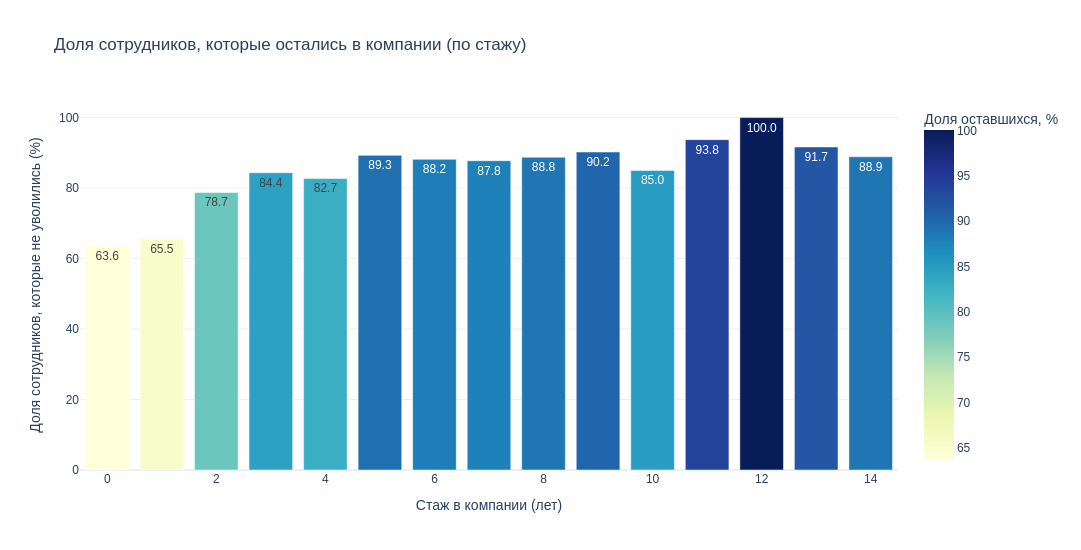

In [21]:
tab = pd.crosstab(df['Стаж в компании'], df['Увольнение'], margins=True)
tab['%_Нет'] = tab.iloc[:,1] / tab['All'] * 100
tab_reset = tab.reset_index().head(15)

# Строим график только по стажу (без строки All)
fig = px.bar(
    tab_reset[tab_reset['Стаж в компании'] != 'All'],  # убираем итоговую строку
    x='Стаж в компании',
    y='%_Нет',
    title='Доля сотрудников, которые остались в компании (по стажу)',
    labels={
        'Стаж в компании': 'Стаж в компании (лет)',
        '%_Нет': 'Доля оставшихся, %'
    },
    text_auto='.1f',
    height=550,
    color='%_Нет',
    color_continuous_scale='YlGnBu'
)

fig.update_traces(textposition='auto', textfont_size=12)
fig.update_layout(
    xaxis_title='Стаж в компании (лет)',
    yaxis_title='Доля сотрудников, которые не уволились (%)',
    yaxis=dict(range=[0, 105]),
    template='plotly_white',
    bargap=0.2
)

fig.show()

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    Имеется сильная корреляция со стажем: если сотрудник удержится в течение двух лет, то вероятность увольнения сильно снижается, и этот тренд держится до пяти лет, после уже тренд становится ровным

# Общий вывод

<div style='border: 2px solid black; padding: 10px; border-radius: 5px;'>

    Проект представляет собой глубокий анализ данных о сотрудниках, направленный на выявление факторов, влияющих на увольнение сотрудников. На основе данных, включая возраст, зарплату, семейное положение, стаж работы, переработки и другие переменные, были проведены различные статистические анализы и проверены гипотезы.

    Основные выводы:

    Текучесть кадров: Большее количество увольнений наблюдается среди сотрудников первого грейда, что может быть связано с неопределённостью на начальных этапах работы. Для более высоких грейдов увольнение связано с другими факторами, такими как потеря интереса к профессиональному росту.

    Зарплата: Гипотеза о том, что низкая зарплата способствует увольнению, поддержана только для сотрудников первого грейда. Для более старших грейдов связь между зарплатой и увольнением не была найдена.

    Переработки: Переработки ассоциированы с повышенным риском увольнения, особенно на младших грейдах, что подтверждается статистически. Однако переработки не объясняются низким уровнем зарплаты, а скорее могут быть связаны с усталостью, нарушением work-life balance или организационными проблемами.

    Семейное положение и возраст: Семейное положение влияет на отток среди сотрудников в возрасте от 25 до 33 лет, в то время как у более молодых сотрудников (18-24 года) влияние семейного статуса на увольнение менее выражено. Анализ возраста показал, что с возрастом вероятность увольнения снижается.

    Отделы и расстояние: Сотрудники из отделов HR и продаж увольняются чаще. Также заметна закономерность, что сотрудники предпочитают работать ближе к дому.

    Ответ на главный вопрос: `Почему сотрудники уходят?`

    Основные факторы, связанные с увольнением, включают низкую зарплату на младших уровнях, переработки, потерю интереса к дальнейшему профессиональному росту на старших уровнях, а также возможное нарушение баланса между работой и личной жизнью.

    Важным индикатором является стаж работы: сотрудники, которые задерживаются в компании более двух лет, имеют меньший риск увольнения.